## Warrick Benchmark (Explicit Scheme)  
**Richards’ Equation (mixed θ-form):**  
$$
\frac{\partial \theta}{\partial t}
\;-\;\frac{\partial}{\partial z}\Bigl[K(\psi)\,\frac{\partial \psi}{\partial z}\Bigr]
\;-\;\frac{\partial K(\psi)}{\partial z}
\;=\;0
$$
- θ = volumetric water content [–]  
- ψ = pressure head [cm]  
- K(ψ) = hydraulic conductivity [cm/s]  

**Benchmark setup (Warrick, 2003):**  
- Soil column depth = 120 cm, discretised every 5 cm (nz = 25)  
- Initial ψ = –202.5 cm (dry profile)  
- Top boundary: ponded ψ = 0 cm, bottom: unit gradient (no-flow)  
- Compare explicit mixed (θ-based) scheme at different Δt  

# INPUT DATA AND MODEL SETUP

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

# —— INPUT SECTION ——
# Grid definition
nz = 25         # number of vertical nodes
dz = 5          # spatial step [cm]

wet  = 0.495    # upper (ponded) moisture content [-]
dry  = 0.24     # initial (dry) moisture content [-]
thr  = 0.124    # residual water content θr [-]
ths  = 0.495    # saturated water content θs [-]
alpha = 0.015   # inverse air-entry suction α [1/cm]
rksat = 1.23e-5 # saturated conductivity Ks [cm/s]
avg = 0         # 0 = arithmetic average, 1 = geometric average

# rm & rn relate to the van Genuchten m and n parameters: n = 1/(1 - m)
rm = 0.5
rn = 1 / (1 - rm)

# —— HYDRAULIC FUNCTIONS ——
def condf(th):
    """
    Compute hydraulic conductivity K(th) from moisture θ:
      - If θ ≥ θs → K = Ks (saturated)
      - Else:
          xx = (θ - θr)/(θs - θr)  [effective saturation]
          K = Ks * xx^0.5 * [1 - (1 - xx^(1/rm))^rm]^2
    th: current moisture content [-]
    returns: K [cm/s]
    """
    if th >= ths:
        return rksat
    xx = (th - thr) / (ths - thr)
    return rksat * (xx**0.5) * (1 - (1 - xx**(1/rm))**rm)**2

def headf(th):
    """
    Compute pressure head ψ(th) from moisture θ:
      - If θ ≥ θs → ψ = 0 (saturated)
      - Else:
          xx = (θ - θr)/(θs - θr)
          ψ = -[xx^(-1/rm) - 1]^(1/rn) / α
    th: current moisture content [-]
    returns: ψ [cm]
    """
    if th >= ths:
        return 0.0
    xx = (th - thr) / (ths - thr)
    return -(xx**(-1/rm) - 1)**(1/rn) / alpha

# —— EXPLICIT FD UPDATE FUNCTION ——
def update(dry, dt, dtdz, dz, nz, wet, water):
    """
    One time-step update of moisture array `water` via explicit θ-form scheme.
    Arguments:
      dry     : initial dry moisture [-]
      dt      : time step [s]
      dtdz    : dt/dz ratio [s/cm]
      dz      : spatial step [cm]
      nz      : number of nodes
      wet     : ponded moisture at top [-]
      water   : numpy array of current θ values [-]
    Returns:
      Updated `water` array after one dt.
    """
    darcy = np.zeros(nz)   # Darcy flux array

    # Top boundary conductivity/head for first flux
    h_old = headf(wet)     # ψ at surface
    c_old = condf(wet)     # K at surface

    # Compute fluxes at midpoints (i-0.5)
    for iz in range(1, nz + 1):
        h_new = headf(water[iz - 1])  # ψ at node
        c_new = condf(water[iz - 1])  # K at node

        # Arithmetic (avg=0) vs geometric average of conductivity
        if avg == 0:
            cond = 0.5 * (c_old + c_new)
        else:
            cond = np.sqrt(c_old * c_new)

        # Darcy flux: -K [dψ/dz - 1] at midpoint
        darcy[iz - 1] = -cond * ((h_new - h_old) / dz - 1)

        # Prepare for next midpoint
        h_old, c_old = h_new, c_new

    # Update moisture via divergence of flux
    for iz in range(1, nz):
        dwater = -dtdz * (darcy[iz] - darcy[iz - 1])
        water[iz - 1] += dwater

    # Bottom boundary: mirror next-to-last value (no-flow)
    water[nz - 1] = water[nz - 2]

    return water

# SIMULATION RUN

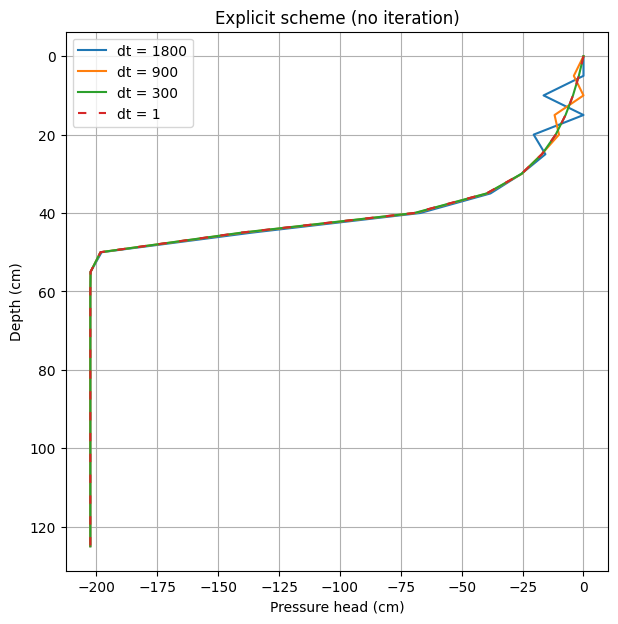

In [ ]:
# List of dt values to run the simulation for
dt_values = [1800, 900, 300, 1]

# Lists to store results for plotting
z_values_list = []
water_values_list = []
head_values_list = []

for dt in dt_values:
    dtdz = dt / dz
    water = np.zeros(nz)  # Initialize water content array

    # Set water array values (Initial condition)
    for iz in range(1, nz+1):
        water[iz - 1] = dry

    # Run the simulation
    sim_time = 360000 # Simulation time in seconds
    t = 0  # set time to 0 and it will run until the simulation time

    z_values = []
    water_values = []
    head_values = []

    while t < sim_time:
        t += dt

        run = update(dry, dt, dtdz, dz, nz, wet, water)

        # Append z, moisture, and head values for plotting (for the last time step)
        z_values = np.hstack([0, [iz * dz for iz in range(1, nz + 1)]])
        head_values = np.hstack([headf(wet), [headf(water[iz - 1]) for iz in range(1, nz + 1)]])
        water_values = np.hstack([wet, [water[iz - 1] for iz in range(1, nz + 1)]])

        # Break out of the loop if the next time step exceeds sim_time
        if t >= sim_time:
            break

    # Append results for this dt value to the lists
    z_values_list.append(z_values)
    water_values_list.append(water_values)
    head_values_list.append(head_values)

# Plotting pressure head for all dt values
plt.figure(figsize=(7, 7))

for i, dt in enumerate(dt_values):
    if dt == 1:
        # Plot with a dashed line for dt=1
        plt.plot(head_values_list[i], z_values_list[i], label=f'dt = {dt}', linestyle='--', dashes=(4, 6))
    else:
        # Plot with a solid line for other dt values
        plt.plot(head_values_list[i], z_values_list[i], label=f'dt = {dt}')

plt.xlabel('Pressure head (cm)')
plt.ylabel('Depth (cm)')
plt.title('Explicit scheme (no iteration)')
plt.gca().invert_yaxis()
plt.legend()
plt.grid(True)
plt.show()

In [ ]:
# —— EXPORT RESULTS ——
import pandas as pd

# Convert arrays to dataframes
z_df = pd.DataFrame({'Depth (cm)': z_values})
theta_df = pd.DataFrame({'Moisture content (-)': water_values})
psi_df = pd.DataFrame({'Pressure head (cm)': head_values})

# Concatenate dataframes along columns
simulation_df = pd.concat([z_df, theta_df, psi_df], axis=1)

# Display the dataframe
print(simulation_df)

    Depth (cm)  Moisture content (-)  Pressure head (cm)
0            0              0.495000            0.000000
1            5              0.494847           -1.918045
2           10              0.494226           -4.313174
3           15              0.492749           -7.378260
4           20              0.489662          -11.433153
5           25              0.483415          -17.062280
6           30              0.470532          -25.491088
7           35              0.442470          -39.838377
8           40              0.380495          -69.670179
9           45              0.282949         -140.601360
10          50              0.242197         -198.352111
11          55              0.240056         -202.418834
12          60              0.240001         -202.525461
13          65              0.240000         -202.528053
14          70              0.240000         -202.528114
15          75              0.240000         -202.528116
16          80              0.2